In [49]:
import json
import mytransform
from torch.utils.data import DataLoader
from dataset import ClimateDataset, ClimateDatasetTime
from model.metric import r_squared, pbias, nse
config = json.load(open('config.json'))


In [50]:
normalize = getattr(mytransform, config["normalize"])
if config['normalize'] == "MeanStdNormalize":
    branch_transform = normalize(
        mean=mytransform.BRANCH_MEAN,
        std=mytransform.BRANCH_STD
    )
    trunk_transform = normalize(
        mean=mytransform.TRUNC_MEAN,
        std=mytransform.TRUNC_STD
    )
    if config['y_normalize']:
        target_transform = normalize(
            mean=mytransform.TARGET_MEAN,
            std=mytransform.TARGET_STD
        )
        target_detransform = mytransform.MeanStdDeNormalize(
            mean=mytransform.TARGET_MEAN,
            std=mytransform.TARGET_STD
        )
    else:
        target_transform = None
        target_detransform = None

# target_transform = None
if config['dataset'] == 'ClimateDataset':
    train_data = ClimateDataset("../Maumee DL/", branch_transform, trunk_transform, target_transform, 'train')
    val_data = ClimateDataset("../Maumee DL/", branch_transform, trunk_transform, target_transform, 'val')
elif config['dataset'] == 'ClimateDatasetTime':
    train_data = ClimateDatasetTime("../Maumee DL/", branch_transform, trunk_transform, target_transform, 'train')
    val_data = ClimateDatasetTime("../Maumee DL/", branch_transform, trunk_transform, target_transform, 'test')
data_loader = DataLoader(train_data, **config['data_loader']['args'], pin_memory=True)
valid_data_loader = DataLoader(val_data, batch_size=20480, num_workers=10, pin_memory=True)

In [51]:
from model import model as module_model
import torch.nn as nn
import torch

best_model_path = "saved/models/Mnist_LeNet/0416_031348/model_best.pth"

activation = getattr(nn, config["activation"])
trunk = module_model.MLP(**config['trunk']['args'], activation=activation)
branch = module_model.MLP(**config['branch']['args'], activation=activation)
z_net = module_model.MLP(**config['z_net']['args'], activation=activation)

if config['arch_name'] == 'TriDeepONet':
    model = module_model.TriDeepONet(trunk, branch, z_net)
model = model.cuda()
model.load_state_dict(torch.load(best_model_path)['state_dict'])

<All keys matched successfully>

In [76]:
train_outputs = []
train_targets = []
model.eval()
for trunk, branch, target in data_loader:
    trunk = trunk.cuda()
    branch = branch.cuda()
    target = target.cuda()
    output = model(trunk, branch)
    train_outputs.append(output.detach())
    train_targets.append(target.detach())
train_outputs = target_detransform(torch.cat(train_outputs)).cpu()
train_targets = target_detransform(torch.cat(train_targets)).cpu()
print("train r squared: ", r_squared(train_outputs, train_targets))
print("train pbias: ", pbias(train_outputs, train_targets))
print("train nse: ", nse(train_outputs, train_targets))


train r squared:  tensor(0.9638)
train pbias:  tensor(-0.2377)
train nse:  tensor(0.9629)


In [58]:
import torch.utils.data as data

# Convert train_outputs and train_targets to a dataset
dataset = data.TensorDataset(train_outputs, train_targets)

# Define the number of samples to select
num_samples = 2000

# Randomly split the dataset to downsample the data
downsampled_dataset, _ = data.random_split(dataset, [num_samples, len(dataset) - num_samples])

# Extract the downsampled train_outputs and train_targets
downsampled_train_outputs, downsampled_train_targets = downsampled_dataset[:]

# Print the downsampled train_outputs and train_targets
print(downsampled_train_outputs.shape)
print(downsampled_train_targets.shape)


torch.Size([2000, 1])
torch.Size([2000, 1])


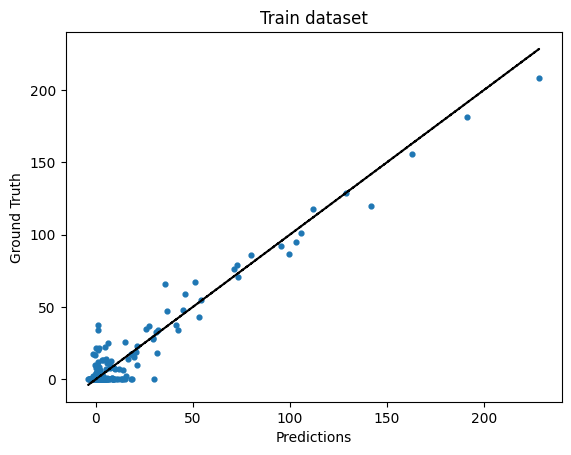

In [60]:
import matplotlib.pyplot as plt
filtered_train_outputs = downsampled_train_outputs[downsampled_train_outputs < 300]
filtered_train_targets = downsampled_train_targets[downsampled_train_outputs < 300]

plt.scatter(filtered_train_outputs.cpu(), filtered_train_targets.cpu(), s=12)
plt.plot(filtered_train_outputs.cpu(), filtered_train_outputs.cpu(), '--', color='black')
plt.xlabel('Predictions')
plt.ylabel('Ground Truth')
plt.title("Train dataset")
plt.show()

# plt.scatter(downsampled_train_outputs.cpu(), downsampled_train_targets.cpu(), s=12)
# plt.plot(downsampled_train_outputs.cpu(), downsampled_train_outputs.cpu(), '--', color='black')
# plt.xlabel('Predictions')
# plt.ylabel('Ground Truth')
# plt.title("Train dataset")
# plt.show()


In [77]:
val_outputs = []
val_targets = []
model.eval()
for trunk, branch, target in valid_data_loader:
    trunk = trunk.cuda()
    branch = branch.cuda()
    target = target.cuda()
    output = model(trunk, branch)
    val_outputs.append(output.detach())
    val_targets.append(target.detach())
val_outputs = target_detransform(torch.cat(val_outputs)).cpu()
val_targets = target_detransform(torch.cat(val_targets)).cpu()
print("val r_squared: ", r_squared(val_outputs, val_targets))
print("val pbias: ", pbias(val_outputs, val_targets))
print("val nse: ", nse(val_outputs, val_targets))


val r_squared:  tensor(0.8951)
val pbias:  tensor(3.7292)
val nse:  tensor(0.8950)


In [73]:
import torch.utils.data as data

# Convert train_outputs and train_targets to a dataset
dataset = data.TensorDataset(val_outputs, val_targets)

# Define the number of samples to select
num_samples = 2000

# Randomly split the dataset to downsample the data
downsampled_dataset, _ = data.random_split(dataset, [num_samples, len(dataset) - num_samples])

# Extract the downsampled train_outputs and train_targets
downsampled_val_outputs, downsampled_val_targets = downsampled_dataset[:]

# Print the downsampled train_outputs and train_targets
print(downsampled_val_outputs.shape)
print(downsampled_val_targets.shape)

torch.Size([2000, 1])
torch.Size([2000, 1])


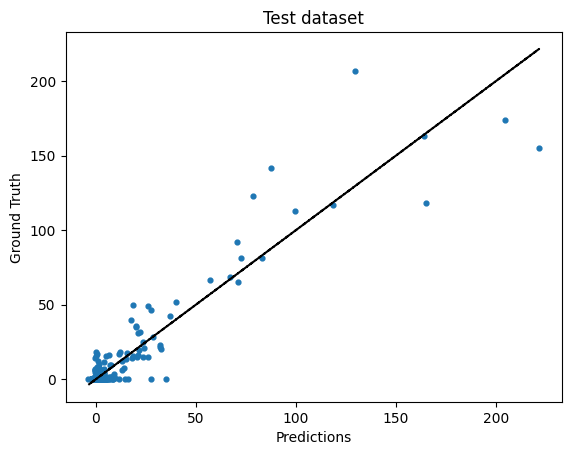

In [74]:
import matplotlib.pyplot as plt
plot_val_outputs = downsampled_val_outputs[downsampled_val_outputs < 300]
plot_val_targets = downsampled_val_targets[downsampled_val_outputs < 300]

plt.scatter(plot_val_outputs.cpu(), plot_val_targets.cpu(), s=12)
plt.plot(plot_val_outputs.cpu(), plot_val_outputs.cpu(), '--', color='black')
plt.xlabel('Predictions')
plt.ylabel('Ground Truth')
plt.title("Test dataset")
plt.show()


In [3]:
from dataset import ClimateDatasetV2
from torch.utils.data import DataLoader
import torch

trainset = ClimateDatasetV2()
loader = DataLoader(trainset, batch_size=20480, num_workers=10, pin_memory=True)
for u, x, y in loader:
    if torch.isnan(u).any():
        print("nan")

torch.Size([206273, 20])
torch.Size([206273, 26])
torch.Size([206273, 294])


In [1]:
import numpy as np

def max_in_columns(arr):
    # Ensure the input is a NumPy array
    arr = np.array(arr)
    
    # Find the maximum value in each column
    max_values = np.max(arr, axis=0)
    
    return max_values

# Example usage
if __name__ == "__main__":
    # Create a sample array
    sample_array = np.array([[3, -1, 7], [4, -2, 8], [1, 5, -9]])
    result = max_in_columns(sample_array)
    print("Array of maximum values in each column:", result)

Array of maximum values in each column: [4 5 8]
